# Random Forest Baseline

Train a RandomForestClassifier on the existing feature set for a tree-based baseline with cross-validation, holdout evaluation, and feature importance visualization.


In [22]:
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
)

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
)

In [23]:
DATA_PATH = "data/grandprix_features_3.csv"
FEATURES = [
    'year',
    'round',
    'avg_race_lap_time_s',
    'lap_delta_vs_event_mean_s',
    'quali_position',
    'prev_points_total',
    'rolling_points_last3',
    'driver_points_per_race',
    'team_prev_points_total',
    'team_points_per_race',
]
TARGET = 'scored_points'
data_path = Path('data/grandprix_features_2.csv')

df_model = pd.read_csv(data_path)

# Ensure new feature columns exist even if using older CSV
defaults = {
    'lap_delta_vs_event_mean_s': 0.0,
    'rolling_points_last3': 0.0,
    'driver_points_per_race': 0.0,
    'team_prev_points_total': 0.0,
    'team_points_per_race': 0.0,
}
for col, val in defaults.items():
    if col not in df_model.columns:
        df_model[col] = val
print(f"Rows after cleaning: {len(df_model)}")
df_model.head()


Rows after cleaning: 1560


,year,round,event,driver,team,quali_position,avg_race_lap_time_s,finish_position,points_awarded,prev_points_total,scored_points,lap_delta_vs_event_mean_s,rolling_points_last3,driver_points_per_race,team_prev_points_total,team_points_per_race
0,2020,1,Austrian Grand Prix,BOT,Mercedes,1.0,68.851635,1.0,25.0,0.0,1,0.0,0.0,0.0,0.0,0.0
1,2020,1,Austrian Grand Prix,LEC,Ferrari,7.0,69.497360,2.0,18.0,0.0,1,0.0,0.0,0.0,0.0,0.0
2,2020,1,Austrian Grand Prix,NOR,McLaren,4.0,69.444060,3.0,16.0,0.0,1,0.0,0.0,0.0,0.0,0.0
3,2020,1,Austrian Grand Prix,HAM,Mercedes,2.0,68.789760,4.0,12.0,0.0,1,0.0,0.0,0.0,0.0,0.0
4,2020,1,Austrian Grand Prix,SAI,McLaren,8.0,69.676180,5.0,10.0,0.0,1,0.0,0.0,0.0,0.0,0.0


In [24]:
X = df_model[FEATURES]
y = df_model[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train.shape, X_test.shape


((1248, 10), (312, 10))

In [25]:
# Random forest baseline (imputer + tree ensemble)
rf = make_pipeline(
    SimpleImputer(strategy='median'),
    RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        n_jobs=-1,
        random_state=42,
        class_weight='balanced',
    ),
)

# Cross-validation: ROC-AUC and PR-AUC (average_precision)
cv_auc = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc')
cv_pr = cross_val_score(rf, X_train, y_train, cv=5, scoring='average_precision')
print(f'CV ROC-AUC: {cv_auc.mean():.3f} ± {cv_auc.std():.3f}')
print(f'CV PR-AUC (avg precision): {cv_pr.mean():.3f} ± {cv_pr.std():.3f}')

# Fit on training data
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

# Holdout evaluation
print('\nHoldout classification report:')
print(classification_report(y_test, y_pred))
print('Holdout ROC-AUC:', roc_auc_score(y_test, y_proba))
print('Holdout PR-AUC (avg precision):', average_precision_score(y_test, y_proba))
print('\nAdditional metrics:')
print('F1 (binary):', f1_score(y_test, y_pred))

CV ROC-AUC: 0.841 ± 0.033
CV PR-AUC (avg precision): 0.817 ± 0.038

Holdout classification report:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       156
           1       0.80      0.82      0.81       156

    accuracy                           0.80       312
   macro avg       0.80      0.80      0.80       312
weighted avg       0.80      0.80      0.80       312

Holdout ROC-AUC: 0.8785749506903353
Holdout PR-AUC (avg precision): 0.8513254462471604

Additional metrics:
F1 (binary): 0.807570977917981


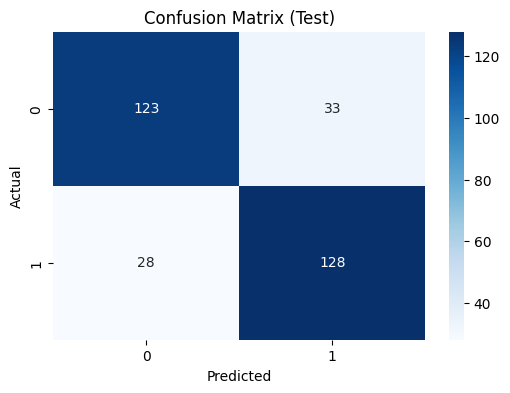

In [26]:
import seaborn as sns
# Confusion matrix (numeric) and visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Test)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()